In [144]:
# !pip install timm torchinfo

## Preprocessing

In [145]:
# !gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
# !unzip -q icdar2003.zip -d datasets

In [146]:
import os
import random
import time
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [147]:
root_dir = './datasets/SceneTrialTrain'

In [148]:
def extract_data(path):
    tree = ET.parse(path)
    root = tree.getroot()

    im_paths, im_sizes, im_labels, im_bboxes = [], [], [], []
    for im in root:
        bboxes = []
        labels = []

        for bbs in im.findall('taggedRectangles'):
            for bb in bbs:
                if not bb[0].text.isalnum():
                    continue
                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bboxes.append(
                    [float(bb.attrib['x']),
                     float(bb.attrib['y']),
                     float(bb.attrib['width']),
                     float(bb.attrib['height'])]
                )
                labels.append(bb[0].text.lower())

        im_paths.append(os.path.join(root_dir, im[0].text))
        im_sizes.append((int(im[1].attrib['x']), int(im[1].attrib['y'])))
        im_labels.append(labels)
        im_bboxes.append(bboxes)

    return im_paths, im_sizes, im_labels, im_bboxes

In [149]:
path = './datasets/SceneTrialTrain/words.xml'
im_paths, im_sizes, im_labels, im_bboxes = extract_data(path)

In [150]:
print(im_paths[0])

./datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG


In [151]:
print(len(im_paths), len(im_sizes), len(im_labels), len(im_bboxes))
print(f'Total number of bounding boxes: {sum([len(bbox) for bbox in im_bboxes])}')

250 250 250 250
Total number of bounding boxes: 1097


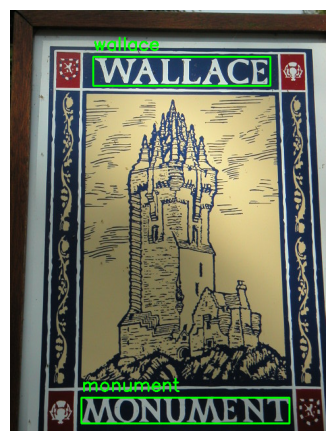

In [ ]:
def plot_bboxes(im_path, im_labels, im_bboxes):
    im = cv2.imread(im_path)
    if im is None:
        print(f'Error: Could not load image at path {im_path}')
        return

    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    for label, bbox in zip(im_labels, im_bboxes):
        x, y, w, h = bbox
        cv2.rectangle(im, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
        cv2.putText(im, label, (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    plt.imshow(im)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

sample_im = random.randint(0, len(im_paths))
plot_bboxes(im_paths[sample_im], im_labels[sample_im], im_bboxes[sample_im])

In [153]:
# Store all bounding boxes as a new dataset
def split_bboxes(im_paths, im_labels, im_bboxes, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    count = 0
    labels = []
    for im_path, im_label, im_bbox in zip(im_paths, im_labels, im_bboxes):
        im = Image.open(im_path)
        for label, bbox in zip(im_label, im_bbox):
            # Crop to the ROI
            cropped_im = im.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))

            # Ignore if cropped image is 90% black or white
            if np.mean(cropped_im) < 35 or np.mean(cropped_im) > 220:
                continue

            # Ignore if cropped image is too small
            if cropped_im.size[0] < 10 or cropped_im.size[1] < 10:
                continue

            # Save the cropped image
            filename = f'{count:06d}.jpg'
            save_path = os.path.join(save_dir, filename)
            cropped_im.save(save_path)

            label = save_path + '\t' + label
            labels.append(label)
            count += 1

    print(f'Created {count} images')
    with open(os.path.join(save_dir, 'labels.txt'), 'w') as f:
        for label in labels:
            f.write(label + '\n')

In [154]:
save_dir = './datasets/ocr_dataset'
split_bboxes(im_paths, im_labels, im_bboxes, save_dir)

Created 1088 images


## Read new dataset

In [155]:
im_paths, im_labels = [], []
with open(os.path.join(save_dir, 'labels.txt'), 'r') as f:
    for label in f:
        im_labels.append(label.strip().split('\t')[1])
        im_paths.append(label.strip().split('\t')[0])

In [156]:
print(f'Total number of images: {len(im_paths)}')
print(im_paths[0])
print(im_labels[0])

Total number of images: 1088
./datasets/ocr_dataset/000000.jpg
self


## Build vocab

In [ ]:
letters = [char.split('.')[0].lower() for char in im_labels]
letters = ''.join(letters)
letters = sorted(set(letters))

chars = ''.join(letters)
blank_char = '-' # for CTC loss
chars += blank_char
vocab_size = len(chars)

print(f'Vocab size: {vocab_size}')
print(chars)

Vocab size: 37
0123456789abcdefghijklmnopqrstuvwxyz-


In [158]:
char2idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx2char = {idx: char for char, idx in char2idx.items()}

In [159]:
max_label_len = max([len(label) for label in im_labels])
print(max_label_len)

14


In [160]:
def encode(label, char2idx, max_label_len):
    encoded_labels = torch.tensor([char2idx[char] for char in label], dtype=torch.long)
    label_len = torch.tensor(len(encoded_labels), dtype=torch.long)
    padded_labels = F.pad(encoded_labels, (0, max_label_len - len(encoded_labels)), value=0)
    return padded_labels, label_len

def decode(encoded_sequences, idx2char, blank_char='-'):
    decoded_sequences = []
    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None

        for token in seq:
            if token != 0: # Ignore padding (token=0)
                char = idx2char[token.item()]
                # Append char if it's not a blank and not the same as the prev char
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char

        decoded_sequences.append(''.join(decoded_label))
    return decoded_sequences

## Build Dataset

In [161]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.Grayscale(num_output_channels=1),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(degrees=1, shear=1),
            transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

In [162]:
seed = 0
val_size = 0.1
test_size = 0.1

X_train, X_val, y_train, y_val = train_test_split(
    im_paths,
    im_labels,
    test_size=val_size,
    random_state=seed,
    shuffle=True,
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=True,
)

In [163]:
class STRDataset(Dataset):
    def __init__(self, X, y, char2idx, max_label_len, label_encoder=None, transform=None):
        self.transform = transform
        self.im_paths = X
        self.im_labels = y
        self.char2idx = char2idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im_label = self.im_labels[idx]

        im = Image.open(im_path).convert('RGB')
        if self.transform:
            im = self.transform(im)

        if self.label_encoder:
            encoded_labels, label_len = self.label_encoder(im_label, self.char2idx, self.max_label_len)

        return im, encoded_labels, label_len

In [164]:
train_dataset = STRDataset(
    X_train, y_train,
    char2idx=char2idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["train"],
)

val_dataset = STRDataset(
    X_val, y_val,
    char2idx=char2idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)

test_dataset = STRDataset(
    X_test, y_test,
    char2idx=char2idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)

In [165]:
print(f'Train size: {len(train_dataset)}')
print(f'Val size: {len(val_dataset)}')
print(f'Test size: {len(test_dataset)}')

Train size: 881
Val size: 109
Test size: 98


In [ ]:
train_batch_size = 64
test_batch_size = 64 * 2

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

Some examples

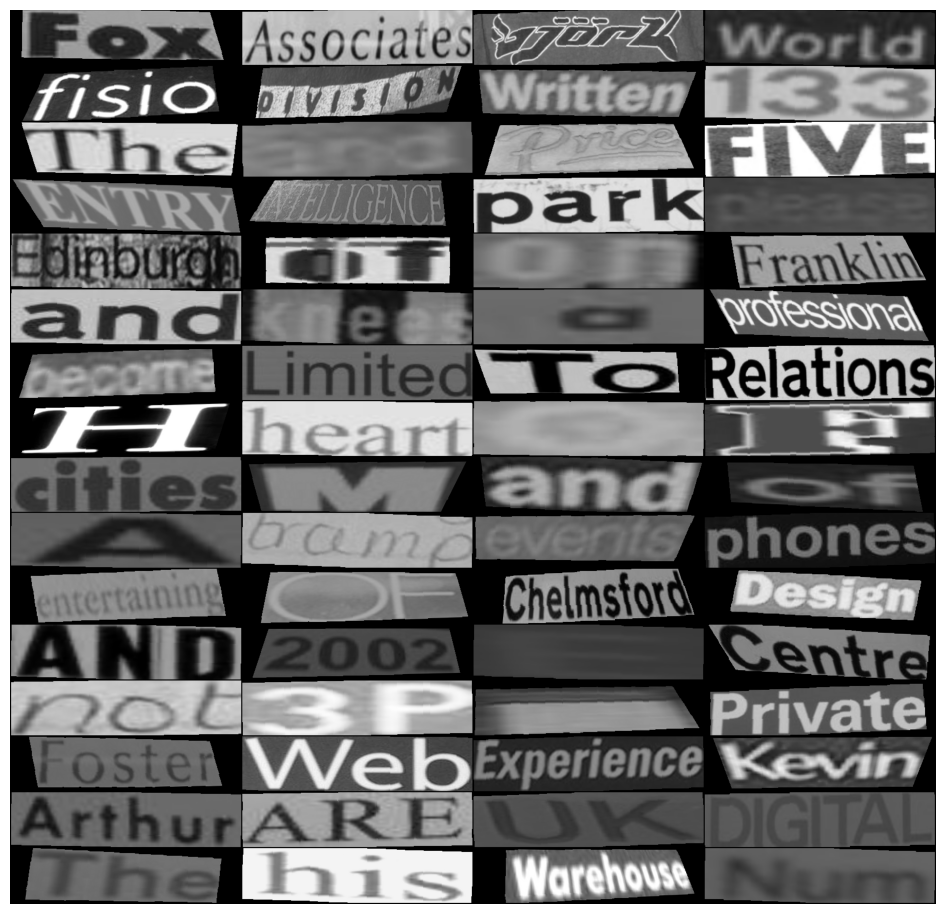

['foc', 'asociates', 'bjork', 'world', 'fisio', 'division', 'writen', '13', 'the', 'and', 'price', 'five', 'entry', 'inteligence', 'park', 'please', 'edinburg', 'of', 'on', 'franklin', 'and', 'knes', 'a', 'profesional', 'become', 'limited', 'to', 'relations', 'h', 'heart', 'o', 'f', 'cities', 'm', 'and', 'of', 'a', 'tramp', 'events', 'phones', 'entertaining', 'of', 'chelmsford', 'design', 'and', '202', 'e', 'centre', 'not', '3p', 'i', 'private', 'foster', 'web', 'experience', 'kevin', 'arthur', 'are', 'uk', 'digital', 'the', 'his', 'warehouse', 'num']


In [167]:
def plot_batch(images, labels):
    plt.figure(figsize=(10, 20))

    labels = decode(labels, idx2char)
    grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)

    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.tight_layout()
    plt.axis('off')
    plt.show()
    print(labels)

for images, labels, label_len in train_loader:
    plot_batch(images, labels)
    break

## Model

In [ ]:
class CRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3):
        super(CRNN, self).__init__()
        
        # Convolutional backbone

        # Load pretrained ResNet-34
        backbone = timm.create_model('resnet34', in_chans=1, pretrained=True)
        # remove last 2 layers and replace with adaptive avg pooling layer
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for param in self.backbone[-unfreeze_layers:].parameters():
            param.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # Recurrent part

        self.gru = nn.GRU(
            input_size=512,
            hidden_size=hidden_size,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )

        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2)
        )

    @torch.autocast(device_type='cuda')
    def forward(self, x):
        # Input shape: (b, c, h, w)
        x = self.backbone(x) # (b, 2048, 1, w)
        x = x.permute(0, 3, 2, 1) # (b, w, 1, 2048)
        x = x.view(x.size(0), x.size(1), -1) # (b, w, 2048)
        x = self.mapSeq(x) # (b, w, 512)
        x, _ = self.gru(x) # (b, w, hidden * 2)
        x = self.layer_norm(x)
        x = self.out(x) # (b, w, vocab)
        x = x.permute(1, 0, 2) # (w, b, vocab) for CTC loss
        return x

In [169]:
hidden_size = 256
n_layers = 3
dropout = 0.2
unfreeze_layers = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CRNN(vocab_size, hidden_size, n_layers, dropout, unfreeze_layers).to(device)

In [170]:
print(model)

CRNN(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

In [171]:
model.eval()

dummy_tensor = torch.rand((64, 1, 100, 420)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)
output.shape

torch.Size([14, 64, 37])

## Training

In [172]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels, labels_len) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_lens = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
    max_grad_norm=5,
):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        start = time.time()
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            logits_lens = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(device)

            loss = criterion(outputs, labels.cpu(), logits_lens.cpu(), labels_len.cpu())
            loss.backward()

            # Debug
            # print(f"Epoch {epoch}, Batch {idx}: Outputs = {outputs}")
            # print(f"Epoch {epoch}, Batch {idx}: Loss = {loss.item()}")

            # Gradient clipping with a configurable max norm to prevent gradient exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(
            f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\t\t Time: {time.time() - start:.2f} seconds"
        )

        scheduler.step()

    return train_losses, val_losses

In [173]:
epochs = 100
lr = 1e-3
weight_decay = 1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(blank=char2idx[blank_char], zero_infinity=True, reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.1)

In [174]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
)

EPOCH 1:	Train loss: 4.7940	Val loss: 3.7355		 Time: 6.88 seconds
EPOCH 2:	Train loss: 3.5118	Val loss: 3.5807		 Time: 7.63 seconds
EPOCH 3:	Train loss: 3.3812	Val loss: 3.4651		 Time: 7.38 seconds
EPOCH 4:	Train loss: 3.2637	Val loss: 3.4005		 Time: 7.03 seconds
EPOCH 5:	Train loss: 3.0919	Val loss: 3.4045		 Time: 7.50 seconds
EPOCH 6:	Train loss: 2.8609	Val loss: 2.7871		 Time: 6.74 seconds
EPOCH 7:	Train loss: 2.5593	Val loss: 2.6969		 Time: 7.66 seconds
EPOCH 8:	Train loss: 2.2334	Val loss: 2.4802		 Time: 6.76 seconds
EPOCH 9:	Train loss: 1.8900	Val loss: 2.0246		 Time: 7.55 seconds
EPOCH 10:	Train loss: 1.5680	Val loss: 2.2314		 Time: 7.00 seconds
EPOCH 11:	Train loss: 1.3515	Val loss: 1.4948		 Time: 7.31 seconds
EPOCH 12:	Train loss: 1.0936	Val loss: 1.3019		 Time: 7.62 seconds
EPOCH 13:	Train loss: 0.9069	Val loss: 1.4224		 Time: 6.83 seconds
EPOCH 14:	Train loss: 0.8003	Val loss: 1.3590		 Time: 7.60 seconds
EPOCH 15:	Train loss: 0.6837	Val loss: 1.0838		 Time: 6.72 seconds
EPOC

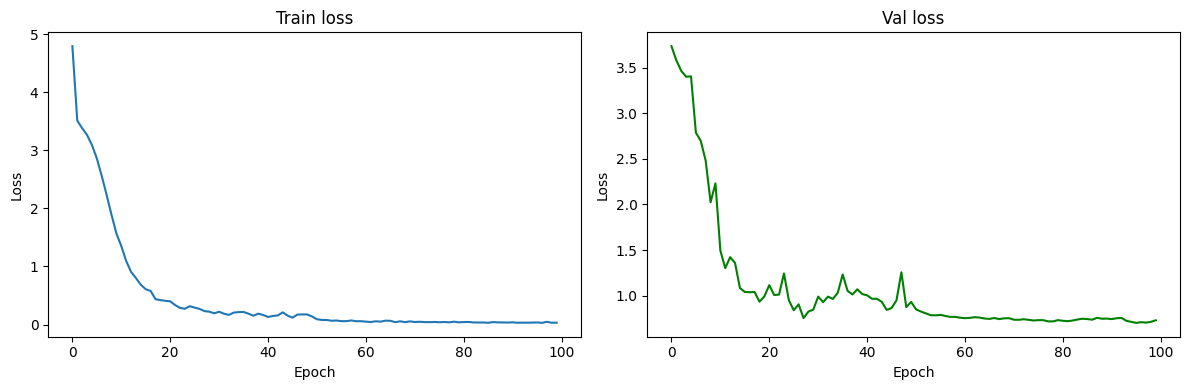

In [175]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(train_losses)
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(val_losses, color='green')
ax[1].set_title('Val loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

## Evaluation

In [176]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print("Val loss: ", val_loss)
print("Test loss: ", test_loss)

Evaluation on val/test dataset
Val loss:  0.7300990223884583
Test loss:  1.1184855699539185


In [177]:
save_model_path = 'ocr_crnn.pt'
torch.save(model.state_dict(), save_model_path)

## Inference

In [178]:
def predict(model, im):
    model.eval()
    with torch.no_grad():
        outputs = model(im)
        print(outputs)

def decode_labels(encoded_sequences, idx2char, blank_char='-'):
    decoded_sequences = []
    for seq in encoded_sequences:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0: # Ignore padding (token=0)
                char = idx2char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)
        decoded_sequences.append(''.join(decoded_label))
    return decoded_sequences

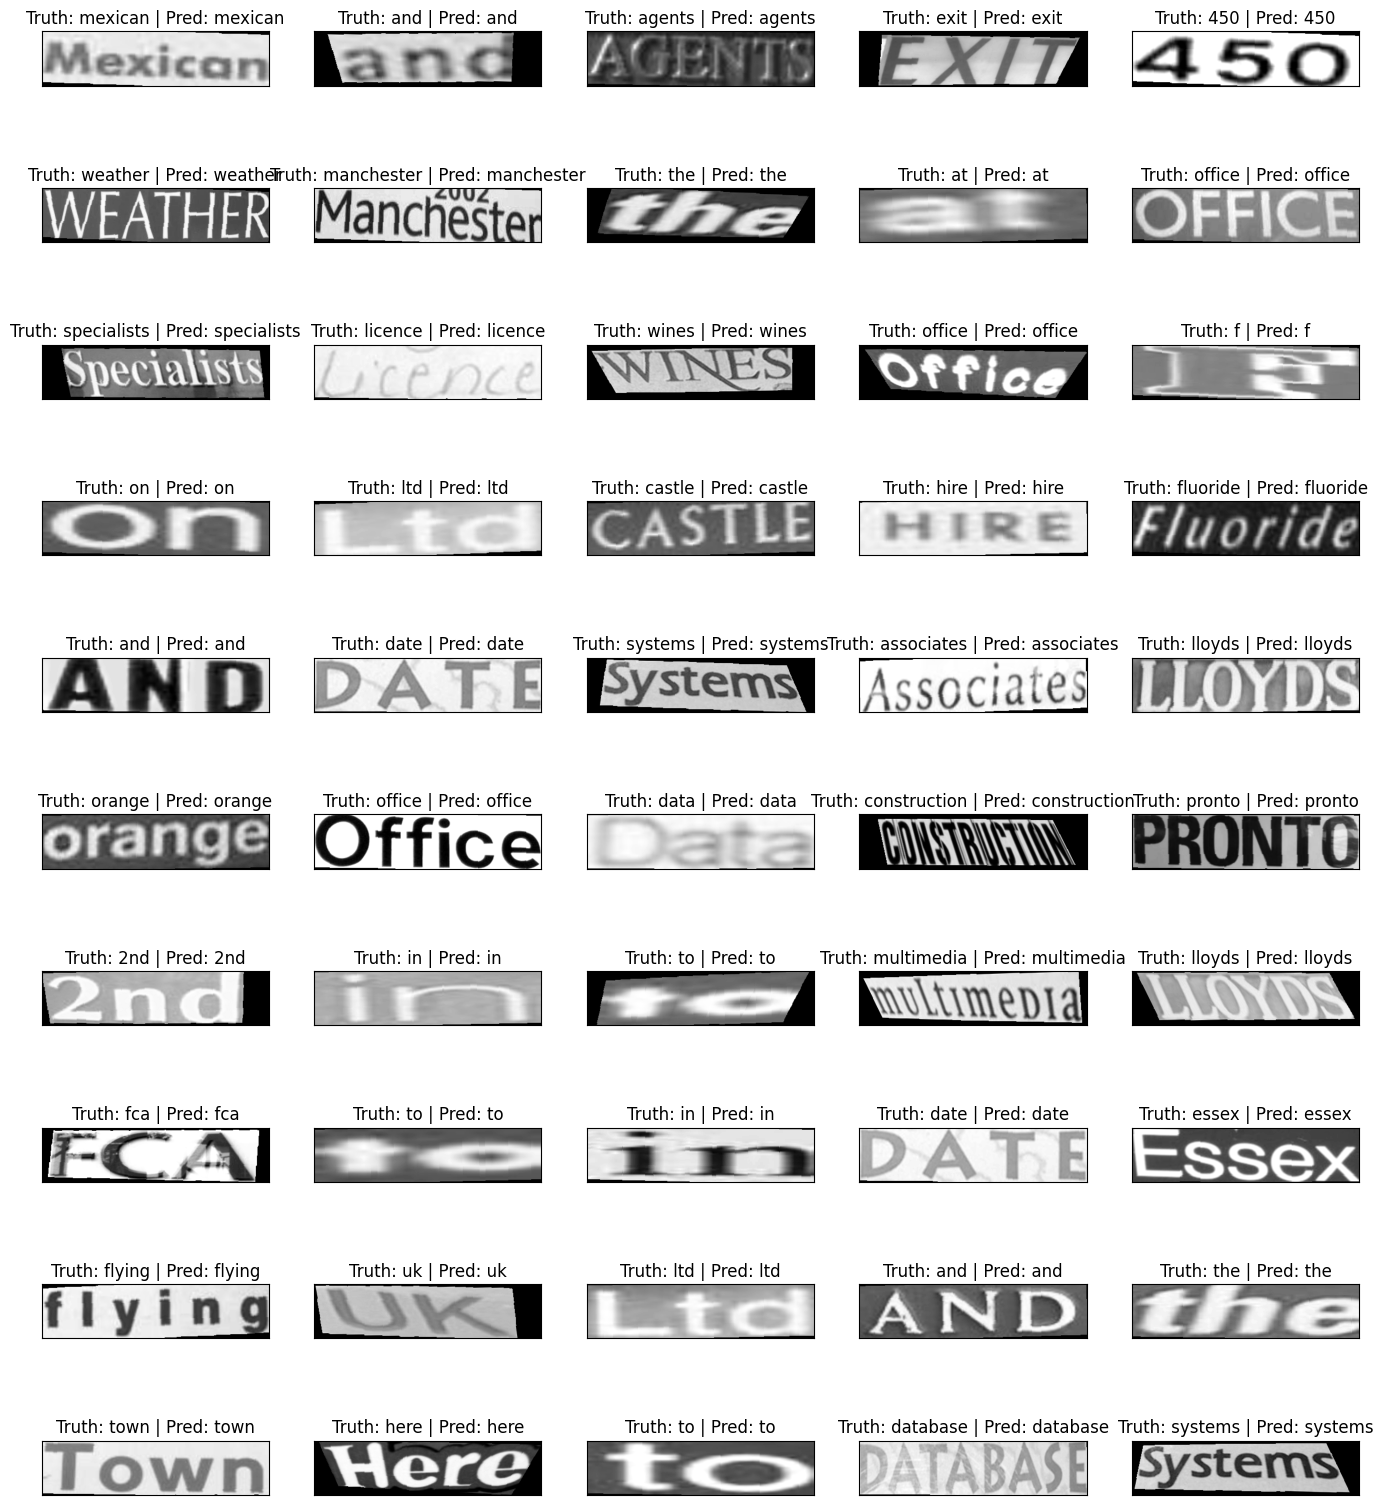

In [179]:
sample_result = []

for i in range(50):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode_labels([label], idx2char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx2char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

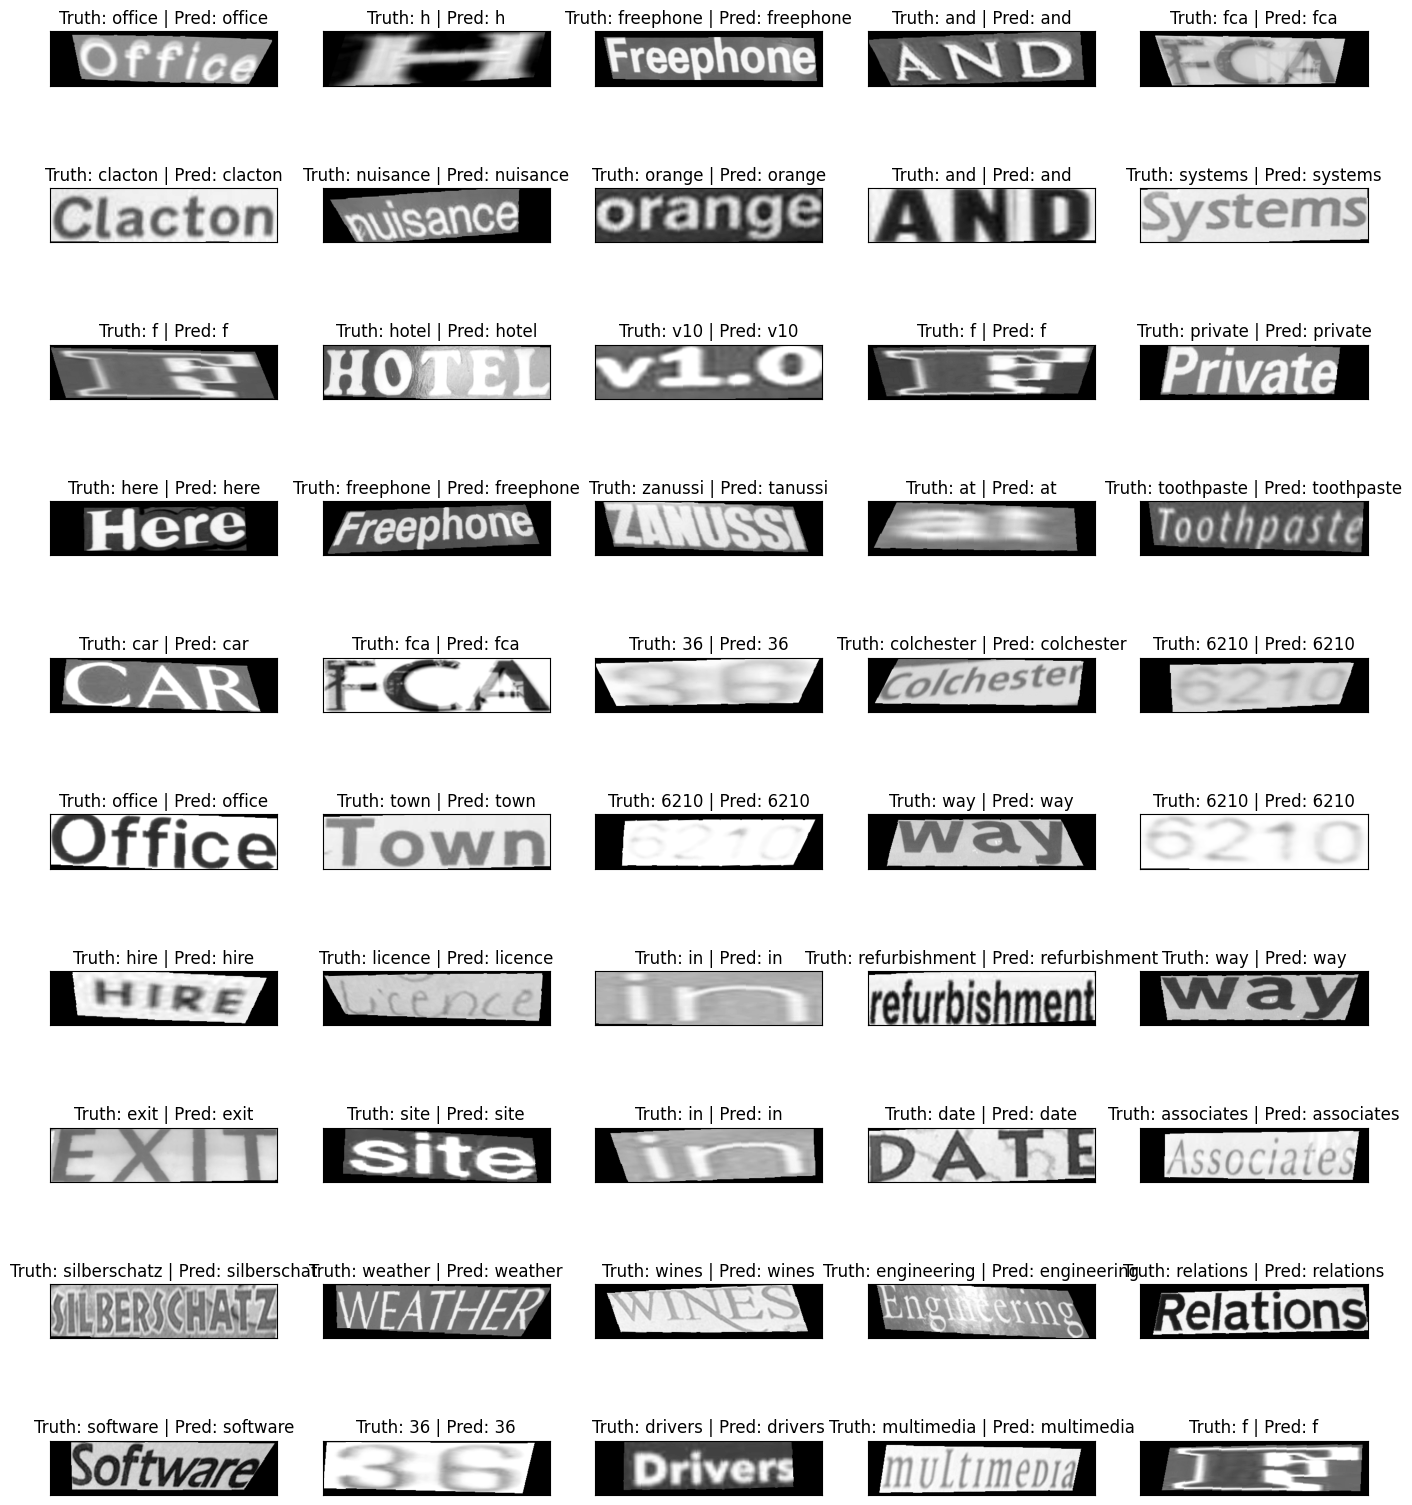

In [180]:
sample_result = []

for i in range(50):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode_labels([label], idx2char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx2char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()